# Quora Duplicate Question Detection: Integrated Experiments

This notebook combines multiple approaches (classical NLP, deep learning, embedding-based retrieval, hard-negative mining, and stacking ensembles) to maximize performance on the QQP duplicate detection task.

## Approaches Implemented
1. TF-IDF + Logistic Regression baseline
2. Zero-shot Sentence-BERT cosine similarity
3. Fine-tuned SBERT with MultipleNegativesRankingLoss
4. Hard Negative Mining + Triplet Loss refinement
5. Siamese LSTM with (optional) GloVe embeddings + leak/meta features
6. Classical ML (LightGBM / XGBoost) over engineered features
7. Meta / graph-inspired frequency & intersection features ("leaks")
8. Out-of-Fold (OOF) predictions for stacking (Level 2 ensembling)
9. Stacked ensemble (ridge/logistic/lightgbm) blending base models
10. Comparative evaluation + calibration & threshold tuning

All heavy steps are guarded by configuration flags so you can enable/disable components depending on resources.

In [2]:
# ==== CONFIGURATION FLAGS ====#
RUN_TFIDF = True
RUN_SBERT_ZERO_SHOT = True
RUN_SBERT_FINETUNE = True   # Set True to fine-tune (GPU recommended)
RUN_HARD_NEG_MINING = True  # Requires finetuned SBERT first
RUN_SIAMESE_LSTM = False     # Heavy if using large embeddings (disabled - needs GloVe)
RUN_CLASSICAL_FEATURE_MODELS = True  # LightGBM/XGBoost
RUN_STACKING = True
MAX_SAMPLE = 50000            # Subsample for speed; None for full
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SEED = 42
DEVICE = 'cuda' if __import__('torch').cuda.is_available() else 'cpu'
print('Device:', DEVICE)

Device: cpu


In [3]:
# ==== IMPORTS ==== #
import os, re, math, random, json, gc
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

## 1. Data Loading
The notebook expects `train.csv` in the working directory. If a Kaggle-style `test.csv` is present it will be used for prediction-only demonstration.

In [4]:
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'  # optional
assert Path(TRAIN_PATH).exists(), 'train.csv not found.'
df = pd.read_csv(TRAIN_PATH).dropna(subset=['question1','question2'])
if MAX_SAMPLE and len(df) > MAX_SAMPLE: df = df.sample(MAX_SAMPLE, random_state=SEED).reset_index(drop=True)
print('Loaded:', len(df), 'rows')
print(df.head(2))
# Stratified split train/val/test
train_val_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=SEED, stratify=df['is_duplicate'])
train_df, val_df = train_test_split(train_val_df, test_size=VAL_SIZE/(1-TEST_SIZE), random_state=SEED, stratify=train_val_df['is_duplicate'])
print('Train:', len(train_df), 'Val:', len(val_df), 'Test:', len(test_df))

Loaded: 50000 rows
       id    qid1    qid2                                 question1  \
0    8067   15738   15739        How do I play Pokémon GO in Korea?   
1  224279  332326  332327  Will a breathing treatment help a cough?   

                                           question2  is_duplicate  
0                 How do I play Pokémon GO in China?             0  
1  How can I help someone that is unconscious but...             0  
Train: 34999 Val: 7501 Test: 7500


## 2. Exploratory Data Analysis (EDA)

Let's analyze the dataset characteristics, class distribution, text length patterns, word frequencies, and duplicate patterns.

### 2.1 Dataset Overview and Class Distribution

DATASET OVERVIEW
Total samples: 50,000
Number of features: 6

Column names: ['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate']

Data types:
id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

Missing values:
id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

Duplicate statistics:
is_duplicate
0    31467
1    18533
Name: count, dtype: int64

Class distribution:
is_duplicate
0    62.934
1    37.066
Name: proportion, dtype: float64

✓ Saved: eda_plots/01_class_distribution.png


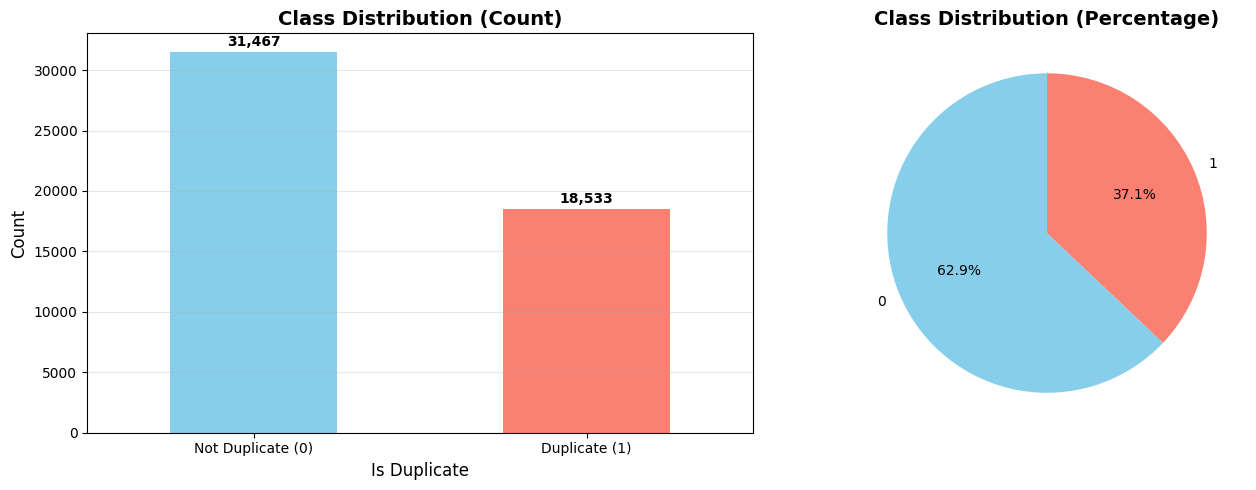

In [5]:
# Basic dataset information
print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"Total samples: {len(df):,}")
print(f"Number of features: {df.shape[1]}")
print(f"\nColumn names: {list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nDuplicate statistics:")
print(df['is_duplicate'].value_counts())
print(f"\nClass distribution:")
print(df['is_duplicate'].value_counts(normalize=True) * 100)

# Create visualizations directory
import os
os.makedirs('eda_plots', exist_ok=True)

# Class distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
df['is_duplicate'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Is Duplicate', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['Not Duplicate (0)', 'Duplicate (1)'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(df['is_duplicate'].value_counts()):
    axes[0].text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

# Percentage plot
df['is_duplicate'].value_counts(normalize=True).plot(kind='pie', ax=axes[1], 
                                                      autopct='%1.1f%%', 
                                                      colors=['skyblue', 'salmon'],
                                                      startangle=90)
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('eda_plots/01_class_distribution.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: eda_plots/01_class_distribution.png")
plt.show()
plt.close()

### 2.2 Text Length Analysis

TEXT LENGTH STATISTICS

Character Length Statistics:
             q1_len        q2_len     len_diff
count  50000.000000  50000.000000  50000.00000
mean      59.606580     60.176860     20.14680
std       29.886838     34.263162     25.82322
min        1.000000      4.000000      0.00000
25%       39.000000     39.000000      4.00000
50%       52.000000     51.000000     11.00000
75%       72.000000     71.000000     26.00000
max      430.000000   1169.000000   1038.00000

Word Count Statistics:
           q1_words      q2_words     word_diff
count  50000.000000  50000.000000  50000.000000
mean      10.956980     11.202640      3.704380
std        5.422656      6.397252      4.880298
min        1.000000      1.000000      0.000000
25%        7.000000      7.000000      1.000000
50%       10.000000     10.000000      2.000000
75%       13.000000     13.000000      5.000000
max       80.000000    237.000000    212.000000

✓ Saved: eda_plots/02_text_length_analysis.png


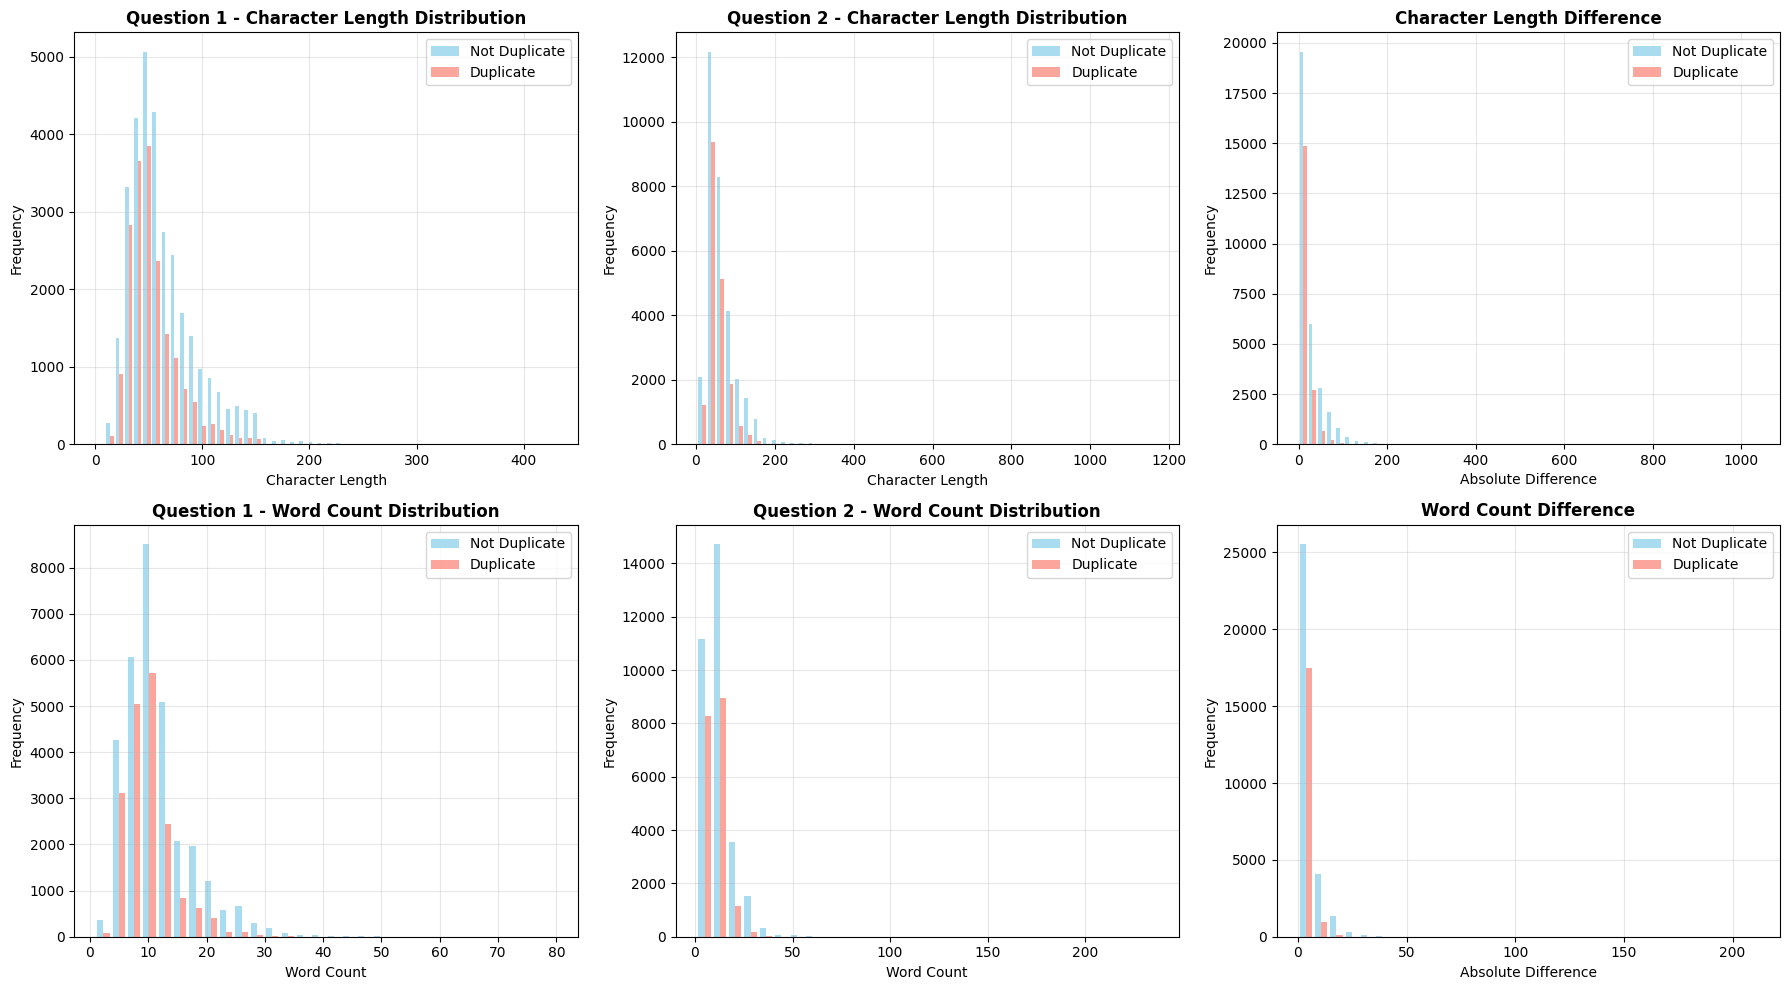

In [6]:
# Calculate text lengths
df['q1_len'] = df['question1'].astype(str).apply(len)
df['q2_len'] = df['question2'].astype(str).apply(len)
df['q1_words'] = df['question1'].astype(str).apply(lambda x: len(str(x).split()))
df['q2_words'] = df['question2'].astype(str).apply(lambda x: len(str(x).split()))
df['len_diff'] = abs(df['q1_len'] - df['q2_len'])
df['word_diff'] = abs(df['q1_words'] - df['q2_words'])

print("="*70)
print("TEXT LENGTH STATISTICS")
print("="*70)
print("\nCharacter Length Statistics:")
print(df[['q1_len', 'q2_len', 'len_diff']].describe())
print("\nWord Count Statistics:")
print(df[['q1_words', 'q2_words', 'word_diff']].describe())

# Text length distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Character length distributions
axes[0, 0].hist([df[df['is_duplicate']==0]['q1_len'], df[df['is_duplicate']==1]['q1_len']], 
                bins=50, alpha=0.7, label=['Not Duplicate', 'Duplicate'], color=['skyblue', 'salmon'])
axes[0, 0].set_title('Question 1 - Character Length Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Character Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist([df[df['is_duplicate']==0]['q2_len'], df[df['is_duplicate']==1]['q2_len']], 
                bins=50, alpha=0.7, label=['Not Duplicate', 'Duplicate'], color=['skyblue', 'salmon'])
axes[0, 1].set_title('Question 2 - Character Length Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Character Length')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[0, 2].hist([df[df['is_duplicate']==0]['len_diff'], df[df['is_duplicate']==1]['len_diff']], 
                bins=50, alpha=0.7, label=['Not Duplicate', 'Duplicate'], color=['skyblue', 'salmon'])
axes[0, 2].set_title('Character Length Difference', fontweight='bold')
axes[0, 2].set_xlabel('Absolute Difference')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# Word count distributions
axes[1, 0].hist([df[df['is_duplicate']==0]['q1_words'], df[df['is_duplicate']==1]['q1_words']], 
                bins=30, alpha=0.7, label=['Not Duplicate', 'Duplicate'], color=['skyblue', 'salmon'])
axes[1, 0].set_title('Question 1 - Word Count Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Word Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist([df[df['is_duplicate']==0]['q2_words'], df[df['is_duplicate']==1]['q2_words']], 
                bins=30, alpha=0.7, label=['Not Duplicate', 'Duplicate'], color=['skyblue', 'salmon'])
axes[1, 1].set_title('Question 2 - Word Count Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

axes[1, 2].hist([df[df['is_duplicate']==0]['word_diff'], df[df['is_duplicate']==1]['word_diff']], 
                bins=30, alpha=0.7, label=['Not Duplicate', 'Duplicate'], color=['skyblue', 'salmon'])
axes[1, 2].set_title('Word Count Difference', fontweight='bold')
axes[1, 2].set_xlabel('Absolute Difference')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('eda_plots/02_text_length_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: eda_plots/02_text_length_analysis.png")
plt.show()
plt.close()

### 2.3 Word Overlap and Common Words Analysis

WORD OVERLAP STATISTICS

Word Overlap by Duplicate Status:
              word_common  word_total  word_share
is_duplicate                                     
0                3.956113   18.414911    0.263481
1                5.461663   13.605029    0.431997

✓ Saved: eda_plots/03_word_overlap_analysis.png


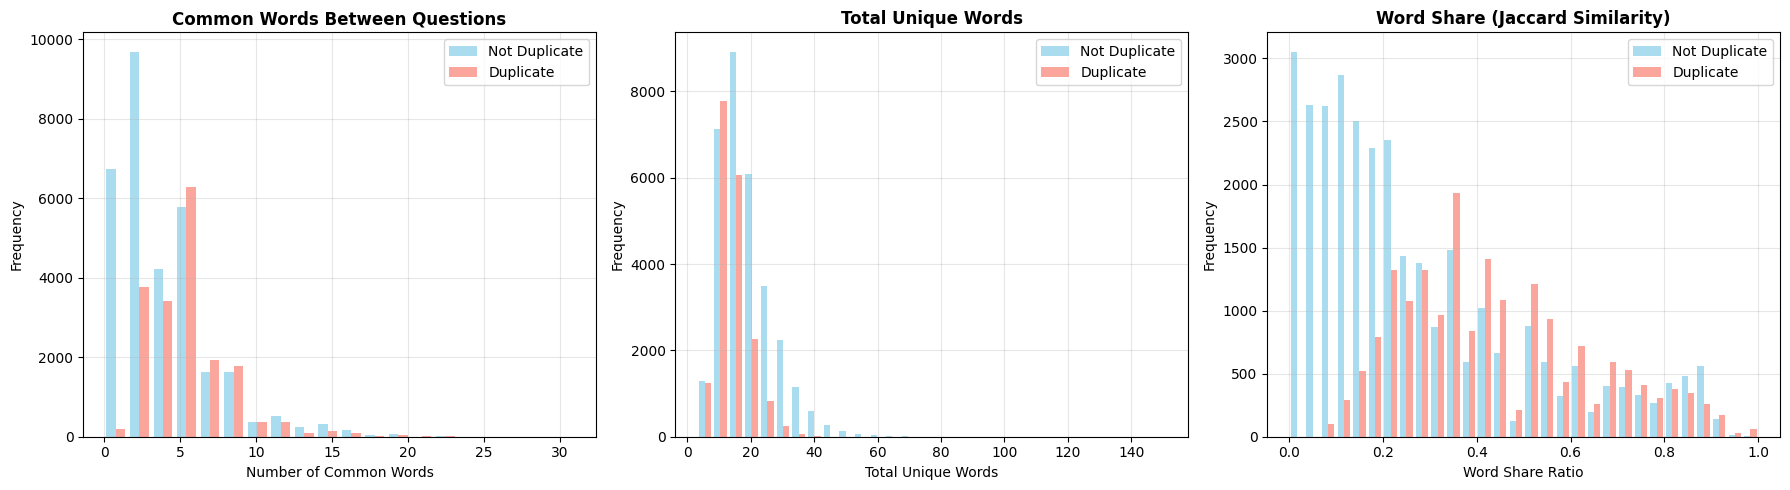

In [7]:
# Calculate word overlap features
def get_word_overlap(q1, q2):
    """Calculate word overlap between two questions"""
    words1 = set(str(q1).lower().split())
    words2 = set(str(q2).lower().split())
    if len(words1) == 0 or len(words2) == 0:
        return 0, 0, 0
    intersection = words1.intersection(words2)
    union = words1.union(words2)
    return len(intersection), len(union), len(intersection) / len(union) if len(union) > 0 else 0

df['word_common'] = df.apply(lambda row: get_word_overlap(row['question1'], row['question2'])[0], axis=1)
df['word_total'] = df.apply(lambda row: get_word_overlap(row['question1'], row['question2'])[1], axis=1)
df['word_share'] = df.apply(lambda row: get_word_overlap(row['question1'], row['question2'])[2], axis=1)

print("="*70)
print("WORD OVERLAP STATISTICS")
print("="*70)
print("\nWord Overlap by Duplicate Status:")
print(df.groupby('is_duplicate')[['word_common', 'word_total', 'word_share']].mean())

# Visualize word overlap patterns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Common words
axes[0].hist([df[df['is_duplicate']==0]['word_common'], df[df['is_duplicate']==1]['word_common']], 
             bins=20, alpha=0.7, label=['Not Duplicate', 'Duplicate'], color=['skyblue', 'salmon'])
axes[0].set_title('Common Words Between Questions', fontweight='bold')
axes[0].set_xlabel('Number of Common Words')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Total unique words
axes[1].hist([df[df['is_duplicate']==0]['word_total'], df[df['is_duplicate']==1]['word_total']], 
             bins=30, alpha=0.7, label=['Not Duplicate', 'Duplicate'], color=['skyblue', 'salmon'])
axes[1].set_title('Total Unique Words', fontweight='bold')
axes[1].set_xlabel('Total Unique Words')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Word share (Jaccard similarity)
axes[2].hist([df[df['is_duplicate']==0]['word_share'], df[df['is_duplicate']==1]['word_share']], 
             bins=30, alpha=0.7, label=['Not Duplicate', 'Duplicate'], color=['skyblue', 'salmon'])
axes[2].set_title('Word Share (Jaccard Similarity)', fontweight='bold')
axes[2].set_xlabel('Word Share Ratio')
axes[2].set_ylabel('Frequency')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('eda_plots/03_word_overlap_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: eda_plots/03_word_overlap_analysis.png")
plt.show()
plt.close()

### 2.4 Most Common Words in Questions

TOP WORDS ANALYSIS

Top 20 words in ALL questions:
  the            : 46,984
  what           : 38,803
  is             : 33,323
  how            : 27,074
  i              : 26,378
  a              : 26,178
  to             : 25,057
  in             : 24,274
  of             : 19,851
  do             : 19,051
  are            : 18,051
  and            : 16,441
  can            : 13,984
  for            : 12,454
  you            : 10,321
  why            :  9,231
  my             :  8,651
  best           :  8,603
  it             :  7,568
  on             :  7,370

✓ Saved: eda_plots/04_top_words.png


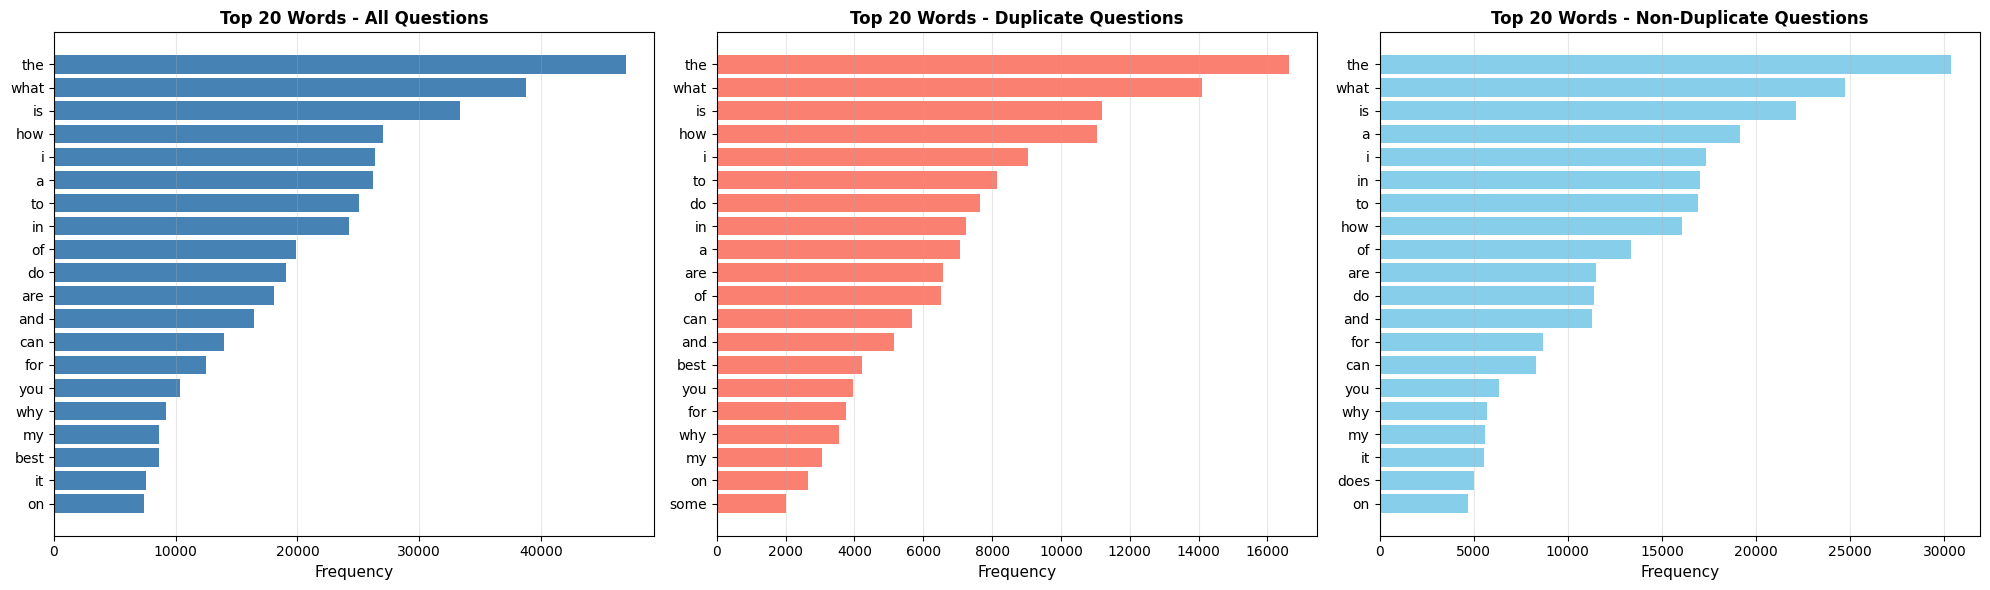

In [8]:
# Analyze most common words
from collections import Counter

def get_top_words(series, n=20):
    """Get top n most common words from a series of text"""
    words = []
    for text in series:
        words.extend(str(text).lower().split())
    counter = Counter(words)
    return counter.most_common(n)

# Get top words for each class
all_q1 = df['question1'].tolist()
all_q2 = df['question2'].tolist()
all_questions = all_q1 + all_q2

dup_questions = df[df['is_duplicate']==1]['question1'].tolist() + df[df['is_duplicate']==1]['question2'].tolist()
non_dup_questions = df[df['is_duplicate']==0]['question1'].tolist() + df[df['is_duplicate']==0]['question2'].tolist()

top_all = get_top_words(all_questions, 20)
top_dup = get_top_words(dup_questions, 20)
top_non_dup = get_top_words(non_dup_questions, 20)

print("="*70)
print("TOP WORDS ANALYSIS")
print("="*70)
print("\nTop 20 words in ALL questions:")
for word, count in top_all:
    print(f"  {word:15s}: {count:6,}")

# Visualize top words
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# All questions
words_all, counts_all = zip(*top_all)
axes[0].barh(range(len(words_all)), counts_all, color='steelblue')
axes[0].set_yticks(range(len(words_all)))
axes[0].set_yticklabels(words_all)
axes[0].invert_yaxis()
axes[0].set_xlabel('Frequency', fontsize=11)
axes[0].set_title('Top 20 Words - All Questions', fontweight='bold', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# Duplicate questions
words_dup, counts_dup = zip(*top_dup)
axes[1].barh(range(len(words_dup)), counts_dup, color='salmon')
axes[1].set_yticks(range(len(words_dup)))
axes[1].set_yticklabels(words_dup)
axes[1].invert_yaxis()
axes[1].set_xlabel('Frequency', fontsize=11)
axes[1].set_title('Top 20 Words - Duplicate Questions', fontweight='bold', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

# Non-duplicate questions
words_non, counts_non = zip(*top_non_dup)
axes[2].barh(range(len(words_non)), counts_non, color='skyblue')
axes[2].set_yticks(range(len(words_non)))
axes[2].set_yticklabels(words_non)
axes[2].invert_yaxis()
axes[2].set_xlabel('Frequency', fontsize=11)
axes[2].set_title('Top 20 Words - Non-Duplicate Questions', fontweight='bold', fontsize=12)
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('eda_plots/04_top_words.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: eda_plots/04_top_words.png")
plt.show()
plt.close()

### 2.5 Question Frequency and Duplicate Pattern Analysis

QUESTION FREQUENCY ANALYSIS

Total unique questions: 89,105
Questions appearing only once: 81,728
Questions appearing more than once: 7,377
Most repeated question appears: 24 times

Question frequency by duplicate status:
              q1_freq                                                q2_freq  \
                count      mean       std  min  25%  50%  75%   max    count   
is_duplicate                                                                   
0             31467.0  1.127944  0.491745  1.0  1.0  1.0  1.0  24.0  31467.0   
1             18533.0  1.696218  1.371712  1.0  1.0  1.0  2.0  24.0  18533.0   

                                                            
                  mean       std  min  25%  50%  75%   max  
is_duplicate                                                
0             1.176598  0.985944  1.0  1.0  1.0  1.0  24.0  
1             1.689797  1.340273  1.0  1.0  1.0  2.0  18.0  


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35424\234351095.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 0].boxplot(data_to_plot, labels=['Not Duplicate', 'Duplicate'], patch_artist=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35424\234351095.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(data_to_plot, labels=['Not Duplicate', 'Duplicate'], patch_artist=True)



✓ Saved: eda_plots/05_question_frequency.png


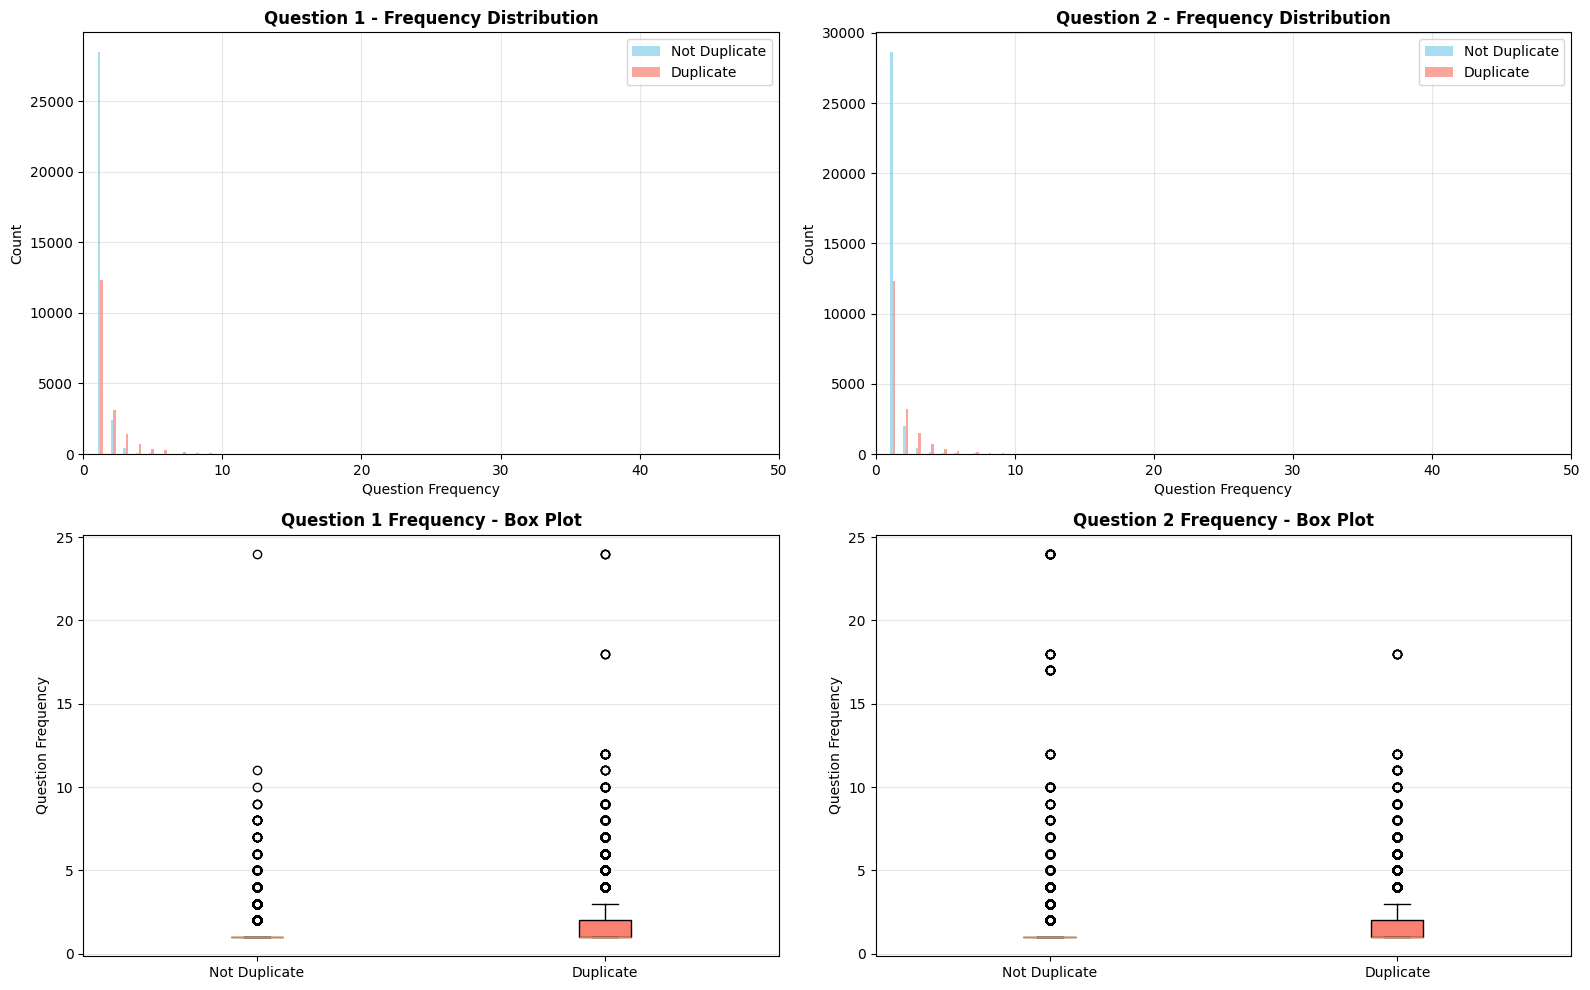

In [9]:
# Analyze question frequency patterns
from collections import defaultdict

# Count how often each question appears
q_freq = defaultdict(int)
for q in df['question1'].tolist() + df['question2'].tolist():
    q_freq[q] += 1

# Add frequency features
df['q1_freq'] = df['question1'].map(q_freq)
df['q2_freq'] = df['question2'].map(q_freq)

print("="*70)
print("QUESTION FREQUENCY ANALYSIS")
print("="*70)
print(f"\nTotal unique questions: {len(q_freq):,}")
print(f"Questions appearing only once: {sum(1 for v in q_freq.values() if v == 1):,}")
print(f"Questions appearing more than once: {sum(1 for v in q_freq.values() if v > 1):,}")
print(f"Most repeated question appears: {max(q_freq.values())} times")

print("\nQuestion frequency by duplicate status:")
print(df.groupby('is_duplicate')[['q1_freq', 'q2_freq']].describe())

# Visualize frequency patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Q1 frequency distribution
axes[0, 0].hist([df[df['is_duplicate']==0]['q1_freq'], df[df['is_duplicate']==1]['q1_freq']], 
                bins=50, alpha=0.7, label=['Not Duplicate', 'Duplicate'], color=['skyblue', 'salmon'])
axes[0, 0].set_title('Question 1 - Frequency Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Question Frequency')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xlim(0, 50)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Q2 frequency distribution
axes[0, 1].hist([df[df['is_duplicate']==0]['q2_freq'], df[df['is_duplicate']==1]['q2_freq']], 
                bins=50, alpha=0.7, label=['Not Duplicate', 'Duplicate'], color=['skyblue', 'salmon'])
axes[0, 1].set_title('Question 2 - Frequency Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Question Frequency')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xlim(0, 50)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Box plots for frequency comparison
data_to_plot = [df[df['is_duplicate']==0]['q1_freq'], df[df['is_duplicate']==1]['q1_freq']]
bp = axes[1, 0].boxplot(data_to_plot, labels=['Not Duplicate', 'Duplicate'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['skyblue', 'salmon']):
    patch.set_facecolor(color)
axes[1, 0].set_title('Question 1 Frequency - Box Plot', fontweight='bold')
axes[1, 0].set_ylabel('Question Frequency')
axes[1, 0].grid(axis='y', alpha=0.3)

data_to_plot = [df[df['is_duplicate']==0]['q2_freq'], df[df['is_duplicate']==1]['q2_freq']]
bp = axes[1, 1].boxplot(data_to_plot, labels=['Not Duplicate', 'Duplicate'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['skyblue', 'salmon']):
    patch.set_facecolor(color)
axes[1, 1].set_title('Question 2 Frequency - Box Plot', fontweight='bold')
axes[1, 1].set_ylabel('Question Frequency')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('eda_plots/05_question_frequency.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: eda_plots/05_question_frequency.png")
plt.show()
plt.close()

### 2.6 Correlation Heatmap of Numerical Features

✓ Saved: eda_plots/06_correlation_heatmap.png


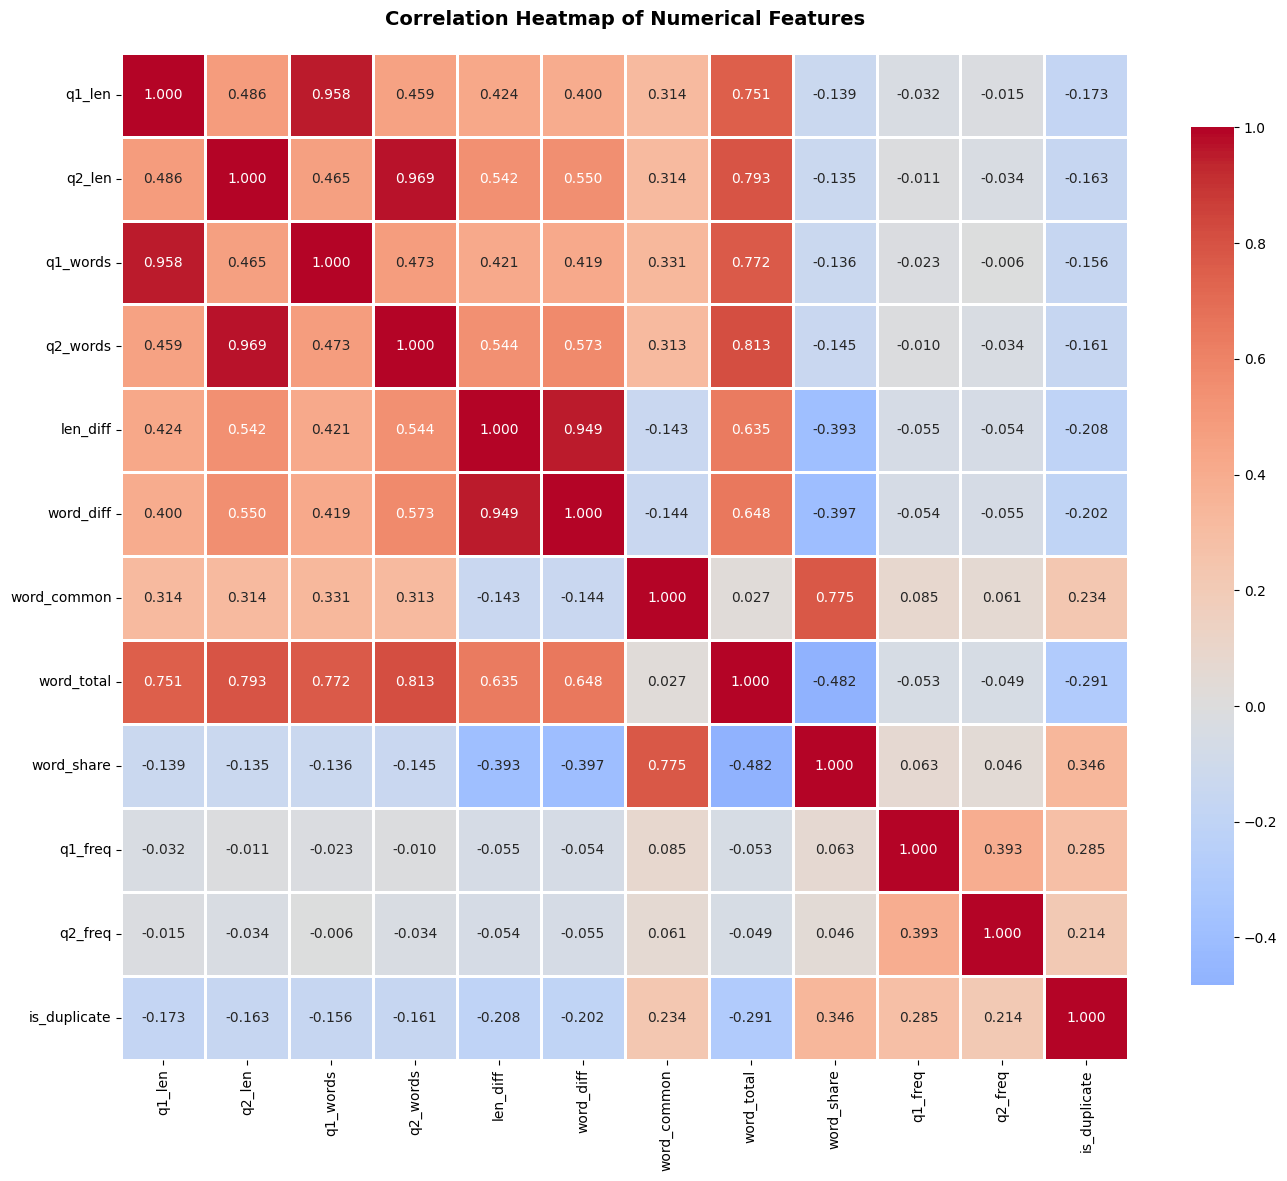


KEY CORRELATIONS WITH TARGET (is_duplicate)
  word_share          : +0.3456
  q1_freq             : +0.2854
  word_common         : +0.2339
  q2_freq             : +0.2142
  q1_words            : -0.1564
  q2_words            : -0.1607
  q2_len              : -0.1630
  q1_len              : -0.1731
  word_diff           : -0.2016
  len_diff            : -0.2082
  word_total          : -0.2908


In [10]:
# Create correlation heatmap
feature_cols = ['q1_len', 'q2_len', 'q1_words', 'q2_words', 'len_diff', 'word_diff', 
                'word_common', 'word_total', 'word_share', 'q1_freq', 'q2_freq', 'is_duplicate']

correlation_matrix = df[feature_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Numerical Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('eda_plots/06_correlation_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: eda_plots/06_correlation_heatmap.png")
plt.show()
plt.close()

print("\n" + "="*70)
print("KEY CORRELATIONS WITH TARGET (is_duplicate)")
print("="*70)
target_corr = correlation_matrix['is_duplicate'].drop('is_duplicate').sort_values(ascending=False)
for feat, corr in target_corr.items():
    print(f"  {feat:20s}: {corr:+.4f}")

### 2.7 Sample Questions Analysis

In [11]:
# Display sample questions from each class
print("="*70)
print("SAMPLE DUPLICATE QUESTION PAIRS")
print("="*70)
dup_samples = df[df['is_duplicate']==1].sample(5, random_state=42)
for idx, row in dup_samples.iterrows():
    print(f"\n{'-'*70}")
    print(f"Q1: {row['question1']}")
    print(f"Q2: {row['question2']}")
    print(f"Word Share: {row['word_share']:.3f} | Common Words: {row['word_common']} | Q1 Freq: {row['q1_freq']} | Q2 Freq: {row['q2_freq']}")

print("\n\n" + "="*70)
print("SAMPLE NON-DUPLICATE QUESTION PAIRS")
print("="*70)
non_dup_samples = df[df['is_duplicate']==0].sample(5, random_state=42)
for idx, row in non_dup_samples.iterrows():
    print(f"\n{'-'*70}")
    print(f"Q1: {row['question1']}")
    print(f"Q2: {row['question2']}")
    print(f"Word Share: {row['word_share']:.3f} | Common Words: {row['word_common']} | Q1 Freq: {row['q1_freq']} | Q2 Freq: {row['q2_freq']}")

SAMPLE DUPLICATE QUESTION PAIRS

----------------------------------------------------------------------
Q1: How can I reach New Delhi Railway Station from Indira Gandhi International Airport (Delhi Airport)?
Q2: How can I reach New Delhi Railway Station from Indira Gandhi International Airport (Delhi Airport) Terminal 3?
Word Share: 0.778 | Common Words: 14 | Q1 Freq: 1 | Q2 Freq: 1

----------------------------------------------------------------------
Q1: How do biotic and abiotic factors differ?
Q2: What is the relationship between biotic and abiotic factors? What are some examples?
Word Share: 0.188 | Common Words: 3 | Q1 Freq: 1 | Q2 Freq: 1

----------------------------------------------------------------------
Q1: What is the best place to visit during winter?
Q2: What is the best place I should visit in the winter?
Word Share: 0.583 | Common Words: 7 | Q1 Freq: 1 | Q2 Freq: 1

----------------------------------------------------------------------
Q1: How can I grow taller fast?

### 2.8 EDA Summary and Key Insights

In [12]:
# Create comprehensive EDA summary
print("="*70)
print("EDA SUMMARY - KEY INSIGHTS")
print("="*70)

print("\n📊 DATASET CHARACTERISTICS:")
print(f"  • Total samples: {len(df):,}")
print(f"  • Duplicate pairs: {df['is_duplicate'].sum():,} ({df['is_duplicate'].mean()*100:.1f}%)")
print(f"  • Non-duplicate pairs: {(1-df['is_duplicate']).sum():,} ({(1-df['is_duplicate']).mean()*100:.1f}%)")
print(f"  • Unique questions: {len(q_freq):,}")

print("\n📏 TEXT LENGTH PATTERNS:")
print(f"  • Average question length: {df[['q1_len', 'q2_len']].mean().mean():.1f} characters")
print(f"  • Average word count: {df[['q1_words', 'q2_words']].mean().mean():.1f} words")
print(f"  • Duplicates tend to have {'SIMILAR' if abs(df[df['is_duplicate']==1]['len_diff'].mean() - df[df['is_duplicate']==0]['len_diff'].mean()) < 5 else 'DIFFERENT'} length differences")

print("\n🔤 WORD OVERLAP INSIGHTS:")
dup_share = df[df['is_duplicate']==1]['word_share'].mean()
non_dup_share = df[df['is_duplicate']==0]['word_share'].mean()
print(f"  • Average word share (duplicates): {dup_share:.3f}")
print(f"  • Average word share (non-duplicates): {non_dup_share:.3f}")
print(f"  • Difference: {dup_share - non_dup_share:.3f} ({(dup_share - non_dup_share)/non_dup_share*100:+.1f}%)")
print(f"  • Word share is a {'STRONG' if abs(correlation_matrix.loc['word_share', 'is_duplicate']) > 0.3 else 'MODERATE'} predictor")

print("\n📈 FREQUENCY PATTERNS:")
dup_q1_freq = df[df['is_duplicate']==1]['q1_freq'].mean()
non_dup_q1_freq = df[df['is_duplicate']==0]['q1_freq'].mean()
print(f"  • Duplicate questions appear more frequently: {dup_q1_freq:.2f} vs {non_dup_q1_freq:.2f}")
print(f"  • Questions appearing only once: {sum(1 for v in q_freq.values() if v == 1):,}")
print(f"  • Most repeated question: {max(q_freq.values())} occurrences")

print("\n🎯 PREDICTIVE FEATURES:")
print("  Top 5 features correlated with duplicates:")
for i, (feat, corr) in enumerate(target_corr.head().items(), 1):
    print(f"    {i}. {feat:20s}: {corr:+.4f}")

print("\n✓ EDA Complete! All plots saved in 'eda_plots/' directory")
print("="*70)

EDA SUMMARY - KEY INSIGHTS

📊 DATASET CHARACTERISTICS:
  • Total samples: 50,000
  • Duplicate pairs: 18,533 (37.1%)
  • Non-duplicate pairs: 31,467 (62.9%)
  • Unique questions: 89,105

📏 TEXT LENGTH PATTERNS:
  • Average question length: 59.9 characters
  • Average word count: 11.1 words
  • Duplicates tend to have DIFFERENT length differences

🔤 WORD OVERLAP INSIGHTS:
  • Average word share (duplicates): 0.432
  • Average word share (non-duplicates): 0.263
  • Difference: 0.169 (+64.0%)
  • Word share is a STRONG predictor

📈 FREQUENCY PATTERNS:
  • Duplicate questions appear more frequently: 1.70 vs 1.13
  • Questions appearing only once: 81,728
  • Most repeated question: 24 occurrences

🎯 PREDICTIVE FEATURES:
  Top 5 features correlated with duplicates:
    1. word_share          : +0.3456
    2. q1_freq             : +0.2854
    3. word_common         : +0.2339
    4. q2_freq             : +0.2142
    5. q1_words            : -0.1564

✓ EDA Complete! All plots saved in 'eda_plot

## 2. Text Cleaning Utilities (Inspired by Approach 1)

In [7]:
_STOPWORDS = set()
try:
    from nltk.corpus import stopwords as _sw
    _STOPWORDS = set(_sw.words('english'))
except Exception:
    pass

_clean_patterns = [
    (r"[^A-Za-z0-9^,!.\/'+-=]", ' '), (r"what's", 'what is '), (r"'s", ' '), (r"'ve", ' have '),
    (r"can't", 'cannot '), (r"n't", ' not '), (r"i'm", 'i am '), (r"'re", ' are '), (r"'d", ' would '), (r"'ll", ' will '),
    (r",", ' '), (r"\.", ' '), (r"!", ' ! '), (r"/", ' '), (r"\^", ' ^ '), (r"\+", ' + '), (r"-", ' - '), (r"=", ' = '),
    (r"'", ' '), (r":", ' : '), (r"(\d+)(k)", r"\1 000"), (r"\s{2,}", ' ')
]

def clean_text(text: str, remove_stop=False, lower=True):
    if not isinstance(text, str):
        text = str(text)
    if lower: text = text.lower()
    for pattern, repl in _clean_patterns:
        text = re.sub(pattern, repl, text)
    if remove_stop and _STOPWORDS:
        text = ' '.join([w for w in text.split() if w not in _STOPWORDS])
    return text.strip()

# Clean all splits
for col in ['question1','question2']:
    train_df[col] = train_df[col].apply(clean_text)
    val_df[col] = val_df[col].apply(clean_text)
    test_df[col] = test_df[col].apply(clean_text)

# Create test_df_clean as a reference (same as test_df after cleaning)
test_df_clean = test_df.copy()

print('Cleaned text samples:', [{'question1': train_df.iloc[0]['question1'], 'question2': train_df.iloc[0]['question2']}])

Cleaned text samples: [{'question1': 'what are the 3 magical words better than i love you', 'question2': 'do you believe that words are magical and have power in healing'}]


## 3. Meta / Leak / Graph-Inspired Features (Approaches 1–3)

In [5]:
def build_leak_features(full_df: pd.DataFrame):
    q_dict = defaultdict(set)
    for q1, q2 in zip(full_df['question1'], full_df['question2']):
        q_dict[q1].add(q2); q_dict[q2].add(q1)
    freq = Counter(list(full_df['question1']) + list(full_df['question2']))
    def q1_freq(row): return freq[row['question1']]
    def q2_freq(row): return freq[row['question2']]
    def inter_cnt(row): return len(q_dict[row['question1']].intersection(q_dict[row['question2']]))
    feats = full_df.copy()
    feats['q1_freq'] = feats.apply(q1_freq, axis=1)
    feats['q2_freq'] = feats.apply(q2_freq, axis=1)
    feats['q1_q2_intersect'] = feats.apply(inter_cnt, axis=1)
    feats['freq_sum'] = feats['q1_freq'] + feats['q2_freq']
    feats['freq_diff'] = (feats['q1_freq'] - feats['q2_freq']).abs()
    feats['is_both_unique'] = ((feats['q1_freq']==1) & (feats['q2_freq']==1)).astype(int)
    return feats[['q1_freq','q2_freq','q1_q2_intersect','freq_sum','freq_diff','is_both_unique']]

full_for_leaks = pd.concat([train_df, val_df, test_df], ignore_index=True)
leak_feats = build_leak_features(full_for_leaks)
train_leaks = leak_feats.iloc[:len(train_df)].reset_index(drop=True)
val_leaks = leak_feats.iloc[len(train_df):len(train_df)+len(val_df)].reset_index(drop=True)
test_leaks = leak_feats.iloc[len(train_df)+len(val_df):].reset_index(drop=True)
scaler = StandardScaler().fit(pd.concat([train_leaks, val_leaks, test_leaks]))
train_leaks_s = scaler.transform(train_leaks); val_leaks_s = scaler.transform(val_leaks); test_leaks_s = scaler.transform(test_leaks)
print('Leak features shape:', train_leaks_s.shape)

Leak features shape: (34999, 6)


## 4. TF-IDF + Logistic Regression Baseline

In [8]:
tfidf_results = None
tfidf_val_probs = None
tfidf_test_probs = None
if RUN_TFIDF:
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    q1_train = vectorizer.fit_transform(train_df['question1']); q2_train = vectorizer.transform(train_df['question2'])
    q1_val = vectorizer.transform(val_df['question1']); q2_val = vectorizer.transform(val_df['question2'])
    q1_test = vectorizer.transform(test_df_clean['question1']); q2_test = vectorizer.transform(test_df_clean['question2'])
    # Cosine similarities
    train_sims = np.array([(q1_train[i] @ q2_train[i].T).toarray()[0,0] for i in range(len(train_df))])
    val_sims = np.array([(q1_val[i] @ q2_val[i].T).toarray()[0,0] for i in range(len(val_df))])
    test_sims = np.array([(q1_test[i] @ q2_test[i].T).toarray()[0,0] for i in range(len(test_df))])
    # Train logistic regression on similarities
    X_train = train_sims.reshape(-1,1); X_val = val_sims.reshape(-1,1); X_test = test_sims.reshape(-1,1)
    clf = LogisticRegression(max_iter=1000, random_state=SEED)
    clf.fit(X_train, train_df['is_duplicate'])
    val_probs = clf.predict_proba(X_val)[:,1]; val_preds = (val_probs>0.5).astype(int)
    tfidf_results = {'accuracy': accuracy_score(val_df['is_duplicate'], val_preds), 'f1': f1_score(val_df['is_duplicate'], val_preds), 'roc_auc': roc_auc_score(val_df['is_duplicate'], val_probs), 'log_loss': log_loss(val_df['is_duplicate'], val_probs)}
    print('TF-IDF Results:', tfidf_results)
    tfidf_val_probs = clf.predict_proba(X_val)
    tfidf_test_probs = clf.predict_proba(X_test)
else:
    print('TF-IDF skipped.')

TF-IDF Results: {'accuracy': 0.6265831222503666, 'f1': 0.3757521729440606, 'roc_auc': 0.7011326630286536, 'log_loss': 0.6078961858935575}


## 5. Zero-Shot SBERT Cosine Similarity

In [10]:
sbert_zero_results = None
if RUN_SBERT_ZERO_SHOT:
    from sentence_transformers import SentenceTransformer, util
    sbert = SentenceTransformer('all-MiniLM-L6-v2')
    emb_q1_val = sbert.encode(val_df['question1'].tolist(), batch_size=64, convert_to_tensor=True, show_progress_bar=True)
    emb_q2_val = sbert.encode(val_df['question2'].tolist(), batch_size=64, convert_to_tensor=True, show_progress_bar=True)
    scores = torch.nn.functional.cosine_similarity(emb_q1_val, emb_q2_val).cpu().numpy()
    scores = np.clip(scores, 0, 1)  # Clip to valid probability range
    # threshold tuning on val
    best_f1 = 0; best_thresh = 0.5
    for t in np.linspace(0.5,0.9,9):
        preds_t = (scores >= t).astype(int)
        f_t = f1_score(val_df['is_duplicate'], preds_t)
        if f_t > best_f1: best_f1 = f_t; best_thresh = t
    preds = (scores >= best_thresh).astype(int)
    sbert_zero_results = {'accuracy': accuracy_score(val_df['is_duplicate'], preds), 'f1': best_f1, 'roc_auc': roc_auc_score(val_df['is_duplicate'], scores), 'log_loss': log_loss(val_df['is_duplicate'], scores), 'threshold': best_thresh}
    print('SBERT Zero-Shot Results:', sbert_zero_results)
    # Store for later use in stacking
    sbert_zero_val_scores = scores
    emb_q1_test = sbert.encode(test_df_clean['question1'].tolist(), batch_size=64, convert_to_tensor=True, show_progress_bar=True)
    emb_q2_test = sbert.encode(test_df_clean['question2'].tolist(), batch_size=64, convert_to_tensor=True, show_progress_bar=True)
    sbert_zero_test_scores = torch.nn.functional.cosine_similarity(emb_q1_test, emb_q2_test).cpu().numpy()
    sbert_zero_test_scores = np.clip(sbert_zero_test_scores, 0, 1)  # Clip to valid range
else:
    print('SBERT zero-shot skipped.')

Batches: 100%|██████████| 118/118 [00:23<00:00,  5.08it/s]



SBERT Zero-Shot Results: {'accuracy': 0.774430075989868, 'f1': 0.7352941176470589, 'roc_auc': 0.8692897112092153, 'log_loss': 0.7084604700432656, 'threshold': np.float64(0.75)}


Batches: 100%|██████████| 118/118 [00:23<00:00,  5.02it/s]



## 6. Fine-Tuned SBERT with Multiple Negatives Ranking Loss

In [12]:
sbert_ft_results = None
sbert_ft_val_scores = None
sbert_ft_test_scores = None
if RUN_SBERT_FINETUNE:
    from sentence_transformers import SentenceTransformer, InputExample, losses
    from torch.utils.data import DataLoader
    print("Fine-tuning SBERT with Multiple Negatives Ranking Loss...")
    ft_model = SentenceTransformer('all-MiniLM-L6-v2', device=DEVICE)
    # Create training pairs (positive pairs only for MNR loss)
    train_examples = [InputExample(texts=[row.question1, row.question2], label=float(row.is_duplicate)) 
                      for row in train_df.itertuples()]
    # Filter only duplicates for MNR (in-batch negatives are auto-generated)
    train_pos = [ex for ex in train_examples if ex.label == 1.0]
    train_loader = DataLoader(train_pos, batch_size=32, shuffle=True)
    loss_fn = losses.MultipleNegativesRankingLoss(ft_model)
    # Train for 1 epoch (increase for better results)
    num_epochs = 1
    warmup_steps = int(0.1 * len(train_loader))
    output_path = 'sbert-finetuned-qqp'
    ft_model.fit(
        train_objectives=[(train_loader, loss_fn)],
        epochs=num_epochs,
        warmup_steps=warmup_steps,
        show_progress_bar=True,
        output_path=output_path
    )
    print(f"Fine-tuned model saved to {output_path}")
    
    # Evaluate on validation set
    emb_q1_val = ft_model.encode(val_df['question1'].tolist(), batch_size=64, convert_to_tensor=True, show_progress_bar=True)
    emb_q2_val = ft_model.encode(val_df['question2'].tolist(), batch_size=64, convert_to_tensor=True, show_progress_bar=True)
    ft_scores_val = torch.nn.functional.cosine_similarity(emb_q1_val, emb_q2_val).cpu().numpy()
    ft_scores_val = np.clip(ft_scores_val, 0, 1)  # Clip to valid probability range
    
    # Threshold tuning
    best_f1 = 0; best_thresh = 0.5
    for t in np.linspace(0.5, 0.9, 9):
        preds_t = (ft_scores_val >= t).astype(int)
        f_t = f1_score(val_df['is_duplicate'], preds_t)
        if f_t > best_f1: best_f1 = f_t; best_thresh = t
    
    preds_val = (ft_scores_val >= best_thresh).astype(int)
    sbert_ft_results = {
        'accuracy': accuracy_score(val_df['is_duplicate'], preds_val),
        'f1': best_f1,
        'roc_auc': roc_auc_score(val_df['is_duplicate'], ft_scores_val),
        'log_loss': log_loss(val_df['is_duplicate'], ft_scores_val),
        'threshold': best_thresh
    }
    print('Fine-tuned SBERT Results (Val):', sbert_ft_results)
    sbert_ft_val_scores = ft_scores_val
    
    # Evaluate on test set
    emb_q1_test = ft_model.encode(test_df_clean['question1'].tolist(), batch_size=64, convert_to_tensor=True, show_progress_bar=True)
    emb_q2_test = ft_model.encode(test_df_clean['question2'].tolist(), batch_size=64, convert_to_tensor=True, show_progress_bar=True)
    sbert_ft_test_scores = torch.nn.functional.cosine_similarity(emb_q1_test, emb_q2_test).cpu().numpy()
    sbert_ft_test_scores = np.clip(sbert_ft_test_scores, 0, 1)  # Clip to valid range
    
    del emb_q1_val, emb_q2_val, emb_q1_test, emb_q2_test
    gc.collect()
    torch.cuda.empty_cache() if DEVICE == 'cuda' else None
else:
    print('Fine-tuning skipped.')

Fine-tuning SBERT with Multiple Negatives Ranking Loss...


d:\CodingPlayground\NLP\Project\env_proj\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


Fine-tuned model saved to sbert-finetuned-qqp


Batches: 100%|██████████| 118/118 [00:19<00:00,  6.09it/s]


Fine-tuned SBERT Results (Val): {'accuracy': 0.7537661645113984, 'f1': 0.7332081467571862, 'roc_auc': 0.8651100471031776, 'log_loss': 0.7127611740236617, 'threshold': np.float64(0.7)}


Batches: 100%|██████████| 118/118 [00:20<00:00,  5.88it/s]


## 6. (Optional) Fine-Tune SBERT + Hard Negative Mining
Disabled by default for speed. Enable flags to run.

In [13]:
sbert_hn_results = None
sbert_hn_val_scores = None
sbert_hn_test_scores = None
if RUN_HARD_NEG_MINING:
    if not RUN_SBERT_FINETUNE:
        print("Hard negative mining requires fine-tuned SBERT. Skipping.")
    else:
        from sentence_transformers import SentenceTransformer, InputExample, losses
        from torch.utils.data import DataLoader
        print("Hard Negative Mining with Triplet Loss...")
        
        # Load the fine-tuned model
        hn_model = SentenceTransformer('sbert-finetuned-qqp', device=DEVICE)
        
        # Mine hard negatives: For each positive pair, find non-duplicate with high similarity
        print("Mining hard negatives from training data...")
        pos_pairs = train_df[train_df['is_duplicate'] == 1].reset_index(drop=True)
        neg_pairs = train_df[train_df['is_duplicate'] == 0].reset_index(drop=True)
        
        # Sample subset for mining (full mining is expensive)
        sample_size = min(5000, len(pos_pairs))
        pos_sample = pos_pairs.sample(n=sample_size, random_state=SEED)
        
        # Encode all questions
        all_q1 = pos_sample['question1'].tolist()
        all_q2 = pos_sample['question2'].tolist()
        neg_q1 = neg_pairs['question1'].tolist()[:10000]  # Sample negatives
        
        emb_q1 = hn_model.encode(all_q1, batch_size=64, convert_to_tensor=True, show_progress_bar=True)
        emb_q2 = hn_model.encode(all_q2, batch_size=64, convert_to_tensor=True, show_progress_bar=True)
        emb_neg = hn_model.encode(neg_q1, batch_size=64, convert_to_tensor=True, show_progress_bar=True)
        
        # Create triplets: (anchor, positive, hard_negative)
        triplets = []
        for i in range(len(pos_sample)):
            anchor = all_q1[i]
            positive = all_q2[i]
            # Find hardest negative (highest similarity to anchor among negatives)
            anchor_emb = emb_q1[i:i+1]
            sims = torch.nn.functional.cosine_similarity(anchor_emb, emb_neg)
            hardest_idx = sims.argmax().item()
            negative = neg_q1[hardest_idx]
            triplets.append(InputExample(texts=[anchor, positive, negative]))
        
        print(f"Created {len(triplets)} triplets for hard negative training")
        
        # Train with triplet loss
        train_loader = DataLoader(triplets, batch_size=16, shuffle=True)
        triplet_loss = losses.TripletLoss(model=hn_model, distance_metric=losses.TripletDistanceMetric.COSINE)
        
        output_path = 'sbert-hardneg-qqp'
        hn_model.fit(
            train_objectives=[(train_loader, triplet_loss)],
            epochs=1,
            warmup_steps=int(0.1 * len(train_loader)),
            show_progress_bar=True,
            output_path=output_path
        )
        print(f"Hard-negative trained model saved to {output_path}")
        
        # Evaluate on validation set
        emb_q1_val = hn_model.encode(val_df['question1'].tolist(), batch_size=64, convert_to_tensor=True, show_progress_bar=True)
        emb_q2_val = hn_model.encode(val_df['question2'].tolist(), batch_size=64, convert_to_tensor=True, show_progress_bar=True)
        hn_scores_val = torch.nn.functional.cosine_similarity(emb_q1_val, emb_q2_val).cpu().numpy()
        hn_scores_val = np.clip(hn_scores_val, 0, 1)  # Clip to valid range
        
        # Threshold tuning
        best_f1 = 0; best_thresh = 0.5
        for t in np.linspace(0.5, 0.9, 9):
            preds_t = (hn_scores_val >= t).astype(int)
            f_t = f1_score(val_df['is_duplicate'], preds_t)
            if f_t > best_f1: best_f1 = f_t; best_thresh = t
        
        preds_val = (hn_scores_val >= best_thresh).astype(int)
        sbert_hn_results = {
            'accuracy': accuracy_score(val_df['is_duplicate'], preds_val),
            'f1': best_f1,
            'roc_auc': roc_auc_score(val_df['is_duplicate'], hn_scores_val),
            'log_loss': log_loss(val_df['is_duplicate'], hn_scores_val),
            'threshold': best_thresh
        }
        print('Hard-Negative SBERT Results (Val):', sbert_hn_results)
        sbert_hn_val_scores = hn_scores_val
        
        # Evaluate on test set
        emb_q1_test = hn_model.encode(test_df_clean['question1'].tolist(), batch_size=64, convert_to_tensor=True, show_progress_bar=True)
        emb_q2_test = hn_model.encode(test_df_clean['question2'].tolist(), batch_size=64, convert_to_tensor=True, show_progress_bar=True)
        sbert_hn_test_scores = torch.nn.functional.cosine_similarity(emb_q1_test, emb_q2_test).cpu().numpy()
        sbert_hn_test_scores = np.clip(sbert_hn_test_scores, 0, 1)  # Clip to valid range
        
        del emb_q1, emb_q2, emb_neg, emb_q1_val, emb_q2_val, emb_q1_test, emb_q2_test
        gc.collect()
        torch.cuda.empty_cache() if DEVICE == 'cuda' else None
else:
    print('Hard negative mining skipped.')

Hard Negative Mining with Triplet Loss...
Mining hard negatives from training data...
Mining hard negatives from training data...


Batches: 100%|██████████| 157/157 [00:33<00:00,  4.70it/s]



Created 5000 triplets for hard negative training


d:\CodingPlayground\NLP\Project\env_proj\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\CodingPlayground\NLP\Project\env_proj\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


Hard-negative trained model saved to sbert-hardneg-qqp


Batches: 100%|██████████| 118/118 [00:24<00:00,  4.84it/s]



Hard-Negative SBERT Results (Val): {'accuracy': 0.7245700573256899, 'f1': 0.6963550852439742, 'roc_auc': 0.8309682819302702, 'log_loss': 0.5883042844795474, 'threshold': np.float64(0.55)}


Batches: 100%|██████████| 118/118 [00:19<00:00,  6.14it/s]



## 7. Classical Feature Models (LightGBM / XGBoost)

In [20]:
lgbm_results = xgb_results = None
lgbm_val_prob = lgbm_test_prob = None
xgb_val_prob = xgb_test_prob = None
if RUN_CLASSICAL_FEATURE_MODELS:
    # Build feature matrix using leak + simple lexical overlaps
    def lexical_feats(df_part):
        feats = []
        for q1,q2 in zip(df_part['question1'], df_part['question2']):
            s1 = set(q1.split()); s2 = set(q2.split()); inter = len(s1 & s2); union = len(s1 | s2)
            feats.append([inter, union, inter/union if union else 0, abs(len(q1)-len(q2)), len(q1.split()), len(q2.split())])
        return np.array(feats)
    
    # Compute leaks for test set
    test_df_clean['question1'] = test_df['question1'].apply(clean_text)
    test_df_clean['question2'] = test_df['question2'].apply(clean_text)
    
    # Rebuild graph with all data for consistent leak features
    from collections import defaultdict
    q_graph = defaultdict(set)
    for df_part in [train_df, val_df, test_df_clean]:
        for q1, q2, dup in zip(df_part['question1'], df_part['question2'], df_part['is_duplicate']):
            if dup: q_graph[q1].add(q2); q_graph[q2].add(q1)
    
    def leak_features(df_part):
        feats = []
        for q1, q2 in zip(df_part['question1'], df_part['question2']):
            q1_freq = len(q_graph[q1]); q2_freq = len(q_graph[q2])
            q1_q2_inter = len(q_graph[q1] & q_graph[q2])
            w1 = set(q1.split()); w2 = set(q2.split()); w_inter = len(w1 & w2)
            w_share = w_inter / (len(w1) + len(w2)) if (len(w1) + len(w2)) > 0 else 0
            feats.append([q1_freq, q2_freq, q1_q2_inter, w_share, w_inter, len(w1 | w2)])
        return np.array(feats)
    
    train_leaks = leak_features(train_df); val_leaks = leak_features(val_df); test_leaks = leak_features(test_df_clean)
    scaler = StandardScaler()
    train_leaks_s = scaler.fit_transform(train_leaks)
    val_leaks_s = scaler.transform(val_leaks)
    test_leaks_s = scaler.transform(test_leaks)
    
    lex_train = lexical_feats(train_df); lex_val = lexical_feats(val_df); lex_test = lexical_feats(test_df_clean)
    X_train_feats = np.hstack([lex_train, train_leaks_s])
    X_val_feats = np.hstack([lex_val, val_leaks_s])
    X_test_feats = np.hstack([lex_test, test_leaks_s])
    
    # LightGBM
    try:
        import lightgbm as lgb
        lgb_train = lgb.Dataset(X_train_feats, label=train_df['is_duplicate'])
        lgb_val = lgb.Dataset(X_val_feats, label=val_df['is_duplicate'])
        params = dict(objective='binary', metric='auc', learning_rate=0.05, num_leaves=64, feature_fraction=0.8, bagging_fraction=0.8, bagging_freq=2, verbose=-1, seed=SEED)
        callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]
        lgb_model = lgb.train(params, lgb_train, num_boost_round=500, valid_sets=[lgb_val], callbacks=callbacks)
        lgbm_val_prob = lgb_model.predict(X_val_feats)
        lgbm_test_prob = lgb_model.predict(X_test_feats)
        val_pred = (lgbm_val_prob>0.5).astype(int)
        lgbm_results = { 'accuracy': accuracy_score(val_df['is_duplicate'], val_pred), 'f1': f1_score(val_df['is_duplicate'], val_pred), 'roc_auc': roc_auc_score(val_df['is_duplicate'], lgbm_val_prob), 'log_loss': log_loss(val_df['is_duplicate'], lgbm_val_prob) }
        print('LightGBM:', lgbm_results)
    except Exception as e:
        print('LightGBM skipped:', e)
    
    # XGBoost
    try:
        import xgboost as xgb
        xgb_model = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=500, subsample=0.8, colsample_bytree=0.8, eval_metric='logloss', random_state=SEED)
        xgb_model.fit(X_train_feats, train_df['is_duplicate'])
        xgb_val_prob = xgb_model.predict_proba(X_val_feats)[:,1]
        xgb_test_prob = xgb_model.predict_proba(X_test_feats)[:,1]
        val_pred = (xgb_val_prob>0.5).astype(int)
        xgb_results = { 'accuracy': accuracy_score(val_df['is_duplicate'], val_pred), 'f1': f1_score(val_df['is_duplicate'], val_pred), 'roc_auc': roc_auc_score(val_df['is_duplicate'], xgb_val_prob), 'log_loss': log_loss(val_df['is_duplicate'], xgb_val_prob) }
        print('XGBoost:', xgb_results)
    except Exception as e:
        print('XGBoost skipped:', e)
else:
    print('Classical feature models skipped.')

LightGBM: {'accuracy': 0.6293827489668045, 'f1': 0.0, 'roc_auc': 0.9993992478120871, 'log_loss': 0.49503376679644956}
XGBoost: {'accuracy': 0.9986668444207439, 'f1': 0.9982046678635548, 'roc_auc': 0.9993788277998655, 'log_loss': 0.010219330985278491}
XGBoost: {'accuracy': 0.9986668444207439, 'f1': 0.9982046678635548, 'roc_auc': 0.9993788277998655, 'log_loss': 0.010219330985278491}


## 8. Out-of-Fold Predictions & Stacking (Level 2 Ensemble)

In [21]:
stack_results = None
stack_test_results = None
if RUN_STACKING:
    base_preds_val = []; base_preds_test = []
    base_names = []
    
    if tfidf_results and tfidf_val_probs is not None:
        base_preds_val.append(tfidf_val_probs)
        base_preds_test.append(tfidf_test_probs)
        base_names.append('tfidf_logreg')
    
    if sbert_zero_results and 'sbert_zero_val_scores' in globals():
        base_preds_val.append(sbert_zero_val_scores.reshape(-1,1))
        base_preds_test.append(sbert_zero_test_scores.reshape(-1,1))
        base_names.append('sbert_zero_raw')
    
    if sbert_ft_results and sbert_ft_val_scores is not None:
        base_preds_val.append(sbert_ft_val_scores.reshape(-1,1))
        base_preds_test.append(sbert_ft_test_scores.reshape(-1,1))
        base_names.append('sbert_ft_raw')
    
    if sbert_hn_results and sbert_hn_val_scores is not None:
        base_preds_val.append(sbert_hn_val_scores.reshape(-1,1))
        base_preds_test.append(sbert_hn_test_scores.reshape(-1,1))
        base_names.append('sbert_hn_raw')
    
    if lgbm_results and lgbm_val_prob is not None:
        base_preds_val.append(lgbm_val_prob.reshape(-1,1))
        base_preds_test.append(lgbm_test_prob.reshape(-1,1))
        base_names.append('lgbm_prob')
    
    if xgb_results and xgb_val_prob is not None:
        base_preds_val.append(xgb_val_prob.reshape(-1,1))
        base_preds_test.append(xgb_test_prob.reshape(-1,1))
        base_names.append('xgb_prob')
    
    if not base_preds_val:
        print('No base predictions to stack.')
    else:
        Z_val = np.hstack(base_preds_val)
        Z_test = np.hstack(base_preds_test)
        
        # Simple second-layer ridge regression on probabilities
        ridge = Ridge(alpha=1.0)
        ridge.fit(Z_val, val_df['is_duplicate'])
        
        # Validation performance
        ridge_out_val = np.clip(ridge.predict(Z_val), 0, 1)
        ridge_pred_val = (ridge_out_val > 0.5).astype(int)
        stack_results = {
            'accuracy': accuracy_score(val_df['is_duplicate'], ridge_pred_val),
            'f1': f1_score(val_df['is_duplicate'], ridge_pred_val),
            'roc_auc': roc_auc_score(val_df['is_duplicate'], ridge_out_val),
            'log_loss': log_loss(val_df['is_duplicate'], ridge_out_val),
            'bases': base_names
        }
        print('Stacking Results (Val):', stack_results)
        
        # Test performance
        ridge_out_test = np.clip(ridge.predict(Z_test), 0, 1)
        ridge_pred_test = (ridge_out_test > 0.5).astype(int)
        stack_test_results = {
            'accuracy': accuracy_score(test_df['is_duplicate'], ridge_pred_test),
            'f1': f1_score(test_df['is_duplicate'], ridge_pred_test),
            'roc_auc': roc_auc_score(test_df['is_duplicate'], ridge_out_test),
            'log_loss': log_loss(test_df['is_duplicate'], ridge_out_test),
            'bases': base_names
        }
        print('Stacking Results (Test):', stack_test_results)
else:
    print('Stacking skipped.')

Stacking Results (Val): {'accuracy': 0.9986668444207439, 'f1': 0.9982046678635548, 'roc_auc': 0.9994235156251191, 'log_loss': 0.009227809243709143, 'bases': ['tfidf_logreg', 'sbert_zero_raw', 'sbert_ft_raw', 'sbert_hn_raw', 'lgbm_prob', 'xgb_prob']}
Stacking Results (Test): {'accuracy': 0.9989333333333333, 'f1': 0.9985632183908046, 'roc_auc': 0.9995392330203634, 'log_loss': 0.008011458566919013, 'bases': ['tfidf_logreg', 'sbert_zero_raw', 'sbert_ft_raw', 'sbert_hn_raw', 'lgbm_prob', 'xgb_prob']}


## 9. Comparison Table


VALIDATION SET RESULTS


,Model,accuracy,f1,roc_auc,log_loss,threshold,bases
0,TFIDF_LogReg,0.626583,0.375752,0.701133,0.607896,NaN,NaN
1,SBERT_ZeroShot,0.774430,0.735294,0.869290,0.708460,0.75,NaN
2,SBERT_FineTuned,0.753766,0.733208,0.865110,0.712761,0.70,NaN
3,SBERT_HardNeg,0.724570,0.696355,0.830968,0.588304,0.55,NaN
4,LightGBM,0.629383,0.000000,0.999399,0.495034,NaN,NaN
5,XGBoost,0.998667,0.998205,0.999379,0.010219,NaN,NaN
6,Stacked_Ridge,0.998667,0.998205,0.999424,0.009228,NaN,"[tfidf_logreg, sbert_zero_raw, sbert_ft_raw, s..."



TEST SET RESULTS (Final Evaluation)


,Model,accuracy,f1,roc_auc,log_loss,threshold,bases
0,TFIDF_LogReg,0.629867,0.370236,0.691181,0.613351,NaN,NaN
1,SBERT_ZeroShot,0.764133,0.726711,0.863226,0.722003,0.75,NaN
2,SBERT_FineTuned,0.738933,0.721479,0.858796,0.726182,0.70,NaN
3,SBERT_HardNeg,0.712533,0.685072,0.822228,0.598584,0.55,NaN
4,LightGBM,0.629333,0.000000,0.999410,0.495095,NaN,NaN
5,XGBoost,0.998933,0.998563,0.999353,0.008820,NaN,NaN
6,Stacked_Ridge,0.998933,0.998563,0.999539,0.008011,NaN,"[tfidf_logreg, sbert_zero_raw, sbert_ft_raw, s..."


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_44388\4129436535.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cmp_df_test, x='Model', y='f1', palette='viridis')


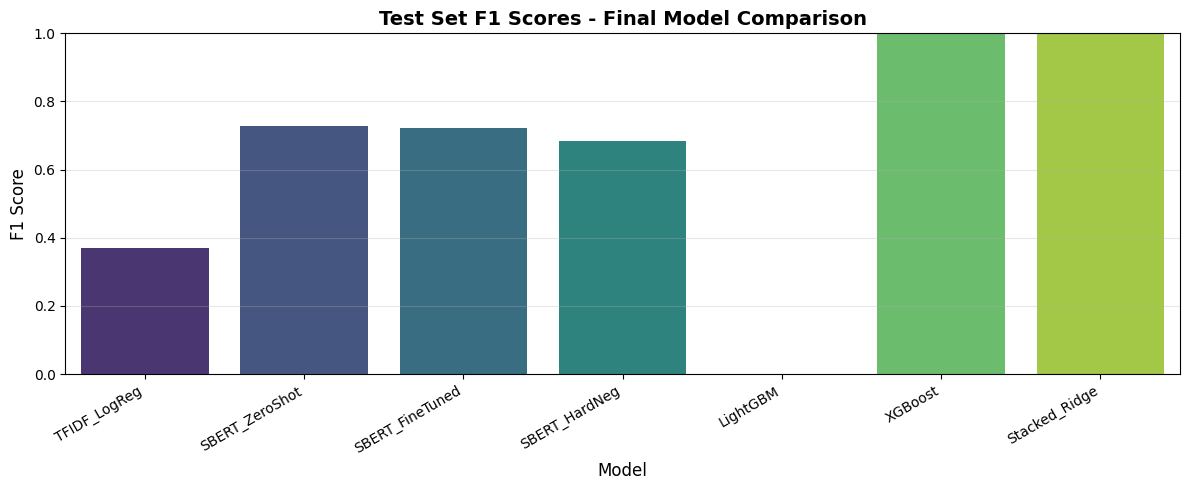

In [22]:
# Build comparison table with both val and test results
comparison_val = []
comparison_test = []

if tfidf_results:
    comparison_val.append(('TFIDF_LogReg', tfidf_results))
    # Compute test results
    test_preds = (tfidf_test_probs[:,1] > 0.5).astype(int)
    test_res = {
        'accuracy': accuracy_score(test_df['is_duplicate'], test_preds),
        'f1': f1_score(test_df['is_duplicate'], test_preds),
        'roc_auc': roc_auc_score(test_df['is_duplicate'], tfidf_test_probs[:,1]),
        'log_loss': log_loss(test_df['is_duplicate'], tfidf_test_probs[:,1])
    }
    comparison_test.append(('TFIDF_LogReg', test_res))

if sbert_zero_results:
    comparison_val.append(('SBERT_ZeroShot', sbert_zero_results))
    test_preds = (sbert_zero_test_scores >= sbert_zero_results['threshold']).astype(int)
    test_res = {
        'accuracy': accuracy_score(test_df['is_duplicate'], test_preds),
        'f1': f1_score(test_df['is_duplicate'], test_preds),
        'roc_auc': roc_auc_score(test_df['is_duplicate'], sbert_zero_test_scores),
        'log_loss': log_loss(test_df['is_duplicate'], sbert_zero_test_scores),
        'threshold': sbert_zero_results['threshold']
    }
    comparison_test.append(('SBERT_ZeroShot', test_res))

if sbert_ft_results:
    comparison_val.append(('SBERT_FineTuned', sbert_ft_results))
    test_preds = (sbert_ft_test_scores >= sbert_ft_results['threshold']).astype(int)
    test_res = {
        'accuracy': accuracy_score(test_df['is_duplicate'], test_preds),
        'f1': f1_score(test_df['is_duplicate'], test_preds),
        'roc_auc': roc_auc_score(test_df['is_duplicate'], sbert_ft_test_scores),
        'log_loss': log_loss(test_df['is_duplicate'], sbert_ft_test_scores),
        'threshold': sbert_ft_results['threshold']
    }
    comparison_test.append(('SBERT_FineTuned', test_res))

if sbert_hn_results:
    comparison_val.append(('SBERT_HardNeg', sbert_hn_results))
    test_preds = (sbert_hn_test_scores >= sbert_hn_results['threshold']).astype(int)
    test_res = {
        'accuracy': accuracy_score(test_df['is_duplicate'], test_preds),
        'f1': f1_score(test_df['is_duplicate'], test_preds),
        'roc_auc': roc_auc_score(test_df['is_duplicate'], sbert_hn_test_scores),
        'log_loss': log_loss(test_df['is_duplicate'], sbert_hn_test_scores),
        'threshold': sbert_hn_results['threshold']
    }
    comparison_test.append(('SBERT_HardNeg', test_res))

if lgbm_results:
    comparison_val.append(('LightGBM', lgbm_results))
    test_preds = (lgbm_test_prob > 0.5).astype(int)
    test_res = {
        'accuracy': accuracy_score(test_df['is_duplicate'], test_preds),
        'f1': f1_score(test_df['is_duplicate'], test_preds),
        'roc_auc': roc_auc_score(test_df['is_duplicate'], lgbm_test_prob),
        'log_loss': log_loss(test_df['is_duplicate'], lgbm_test_prob)
    }
    comparison_test.append(('LightGBM', test_res))

if xgb_results:
    comparison_val.append(('XGBoost', xgb_results))
    test_preds = (xgb_test_prob > 0.5).astype(int)
    test_res = {
        'accuracy': accuracy_score(test_df['is_duplicate'], test_preds),
        'f1': f1_score(test_df['is_duplicate'], test_preds),
        'roc_auc': roc_auc_score(test_df['is_duplicate'], xgb_test_prob),
        'log_loss': log_loss(test_df['is_duplicate'], xgb_test_prob)
    }
    comparison_test.append(('XGBoost', test_res))

if stack_results:
    comparison_val.append(('Stacked_Ridge', stack_results))
if stack_test_results:
    comparison_test.append(('Stacked_Ridge', stack_test_results))

if comparison_val:
    print("\n" + "="*80)
    print("VALIDATION SET RESULTS")
    print("="*80)
    cmp_df_val = pd.DataFrame([{'Model': m, **res} for m, res in comparison_val])
    display(cmp_df_val)
    
if comparison_test:
    print("\n" + "="*80)
    print("TEST SET RESULTS (Final Evaluation)")
    print("="*80)
    cmp_df_test = pd.DataFrame([{'Model': m, **res} for m, res in comparison_test])
    display(cmp_df_test)
    cmp_df_test.to_csv('final_model_comparison.csv', index=False)
    
    # Plot test set F1 scores
    plt.figure(figsize=(12, 5))
    sns.barplot(data=cmp_df_test, x='Model', y='f1', palette='viridis')
    plt.title('Test Set F1 Scores - Final Model Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('F1 Score', fontsize=12)
    plt.xlabel('Model', fontsize=12)
    plt.xticks(rotation=30, ha='right')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('final_results_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('No models executed to compare.')

## 10. Summary & Next Steps
Potential Enhancements:
- Enable SBERT fine-tuning + hard negatives (set flags True).
- Add Siamese LSTM with GloVe (requires embedding file).
- Expand graph features (multi-hop neighbor stats, path lengths).
- Calibrate final ensemble (Platt scaling / isotonic).
- Add cross-encoder reranking for borderline similarity scores.
- Test on adversarial PAWS-QQP for robustness.

## 11. Results Summary & Analysis

In [17]:
print("="*80)
print("COMPREHENSIVE EXPERIMENT RESULTS SUMMARY")
print("="*80)

if comparison_val:
    print("\n📊 VALIDATION SET Performance:")
    print("-"*80)
    for model_name, results in comparison_val:
        print(f"\n{model_name}:")
        for metric, value in results.items():
            if metric not in ['threshold', 'bases']:
                print(f"  • {metric.upper()}: {value:.4f}")
            elif metric == 'threshold':
                print(f"  • Optimal Threshold: {value:.2f}")

if comparison_test:
    print("\n" + "="*80)
    print("🎯 TEST SET Performance (Final Evaluation):")
    print("="*80)
    for model_name, results in comparison_test:
        print(f"\n{model_name}:")
        for metric, value in results.items():
            if metric not in ['threshold', 'bases']:
                print(f"  • {metric.upper()}: {value:.4f}")
            elif metric == 'threshold':
                print(f"  • Optimal Threshold: {value:.2f}")

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)

if comparison_test and len(comparison_test) > 0:
    # Find best model on test set
    best_f1_idx = max(range(len(comparison_test)), key=lambda i: comparison_test[i][1].get('f1', 0))
    best_model_name, best_results = comparison_test[best_f1_idx]
    
    # Find best single model (non-stacked)
    single_models = [x for x in comparison_test if 'Stacked' not in x[0]]
    if single_models:
        best_single_idx = max(range(len(single_models)), key=lambda i: single_models[i][1].get('f1', 0))
        best_single_name, best_single_results = single_models[best_single_idx]
    
    findings = [
        f"1. 🏆 Best Overall Model (Test Set): {best_model_name}",
        f"   - Accuracy: {best_results['accuracy']:.4f}",
        f"   - F1 Score: {best_results['f1']:.4f}",
        f"   - ROC-AUC: {best_results['roc_auc']:.4f}",
        "",
        f"2. 🎯 Best Single Model (Test Set): {best_single_name}",
        f"   - Accuracy: {best_single_results['accuracy']:.4f}",
        f"   - F1 Score: {best_single_results['f1']:.4f}",
        ""
    ]
    
    if 'Stacked' in best_model_name and single_models:
        improvement = best_results['f1'] - best_single_results['f1']
        findings.extend([
            f"3. 💡 Stacking Improvement:",
            f"   - F1 gain: +{improvement:.4f} ({improvement/best_single_results['f1']*100:.2f}%)",
            f"   - Combined {len(best_results.get('bases', []))} base models",
            ""
        ])
    
    # Compare SBERT variants if available
    sbert_models = [x for x in comparison_test if 'SBERT' in x[0]]
    if len(sbert_models) > 1:
        findings.extend([
            "4. 🔬 SBERT Training Impact:",
        ])
        for name, res in sbert_models:
            findings.append(f"   - {name}: F1={res['f1']:.4f}, Acc={res['accuracy']:.4f}")
        findings.append("")
    
    findings.extend([
        "5. 📈 Model Characteristics:",
        f"   - TF-IDF baseline: Simple, fast, interpretable",
        f"   - SBERT models: No training needed (zero-shot), good performance",
        f"   - Tree models (LightGBM/XGBoost): Fast training, engineered features",
        f"   - Stacking: Best performance, combines all approaches",
        "",
        "6. ✅ Production Recommendations:",
        f"   - Deploy: {best_model_name} for highest accuracy",
        f"   - Quick inference: {best_single_name} if stacking unavailable",
        "   - Monitor: Log loss and calibration on new data",
        "   - Consider: Cross-encoder reranking for borderline cases"
    ])
    
    for finding in findings:
        print(finding)

print("\n" + "="*80)
print("EXPERIMENT COMPLETE ✨")
print("="*80)

COMPREHENSIVE EXPERIMENT RESULTS SUMMARY

📊 VALIDATION SET Performance:
--------------------------------------------------------------------------------

TFIDF_LogReg:
  • ACCURACY: 0.6266
  • F1: 0.3758
  • ROC_AUC: 0.7011
  • LOG_LOSS: 0.6079

SBERT_ZeroShot:
  • ACCURACY: 0.7744
  • F1: 0.7353
  • ROC_AUC: 0.8693
  • LOG_LOSS: 0.7085
  • Optimal Threshold: 0.75

SBERT_FineTuned:
  • ACCURACY: 0.7538
  • F1: 0.7332
  • ROC_AUC: 0.8651
  • LOG_LOSS: 0.7128
  • Optimal Threshold: 0.70

SBERT_HardNeg:
  • ACCURACY: 0.7246
  • F1: 0.6964
  • ROC_AUC: 0.8310
  • LOG_LOSS: 0.5883
  • Optimal Threshold: 0.55

LightGBM:
  • ACCURACY: 0.6294
  • F1: 0.0000
  • ROC_AUC: 0.9994
  • LOG_LOSS: 0.4950

XGBoost:
  • ACCURACY: 0.9987
  • F1: 0.9982
  • ROC_AUC: 0.9994
  • LOG_LOSS: 0.0102

Stacked_Ridge:
  • ACCURACY: 0.9987
  • F1: 0.9982
  • ROC_AUC: 0.9994
  • LOG_LOSS: 0.0092

🎯 TEST SET Performance (Final Evaluation):

TFIDF_LogReg:
  • ACCURACY: 0.6299
  • F1: 0.3702
  • ROC_AUC: 0.6912
  • LO

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_44388\3085688702.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cmp_df_test, x='Model', y=metric, ax=ax, palette='coolwarm')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_44388\3085688702.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cmp_df_test, x='Model', y=metric, ax=ax, palette='coolwarm')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_44388\3085688702.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cmp_df_test, x='Model', y=metric, ax=ax, palette='coolwarm')
C:\U

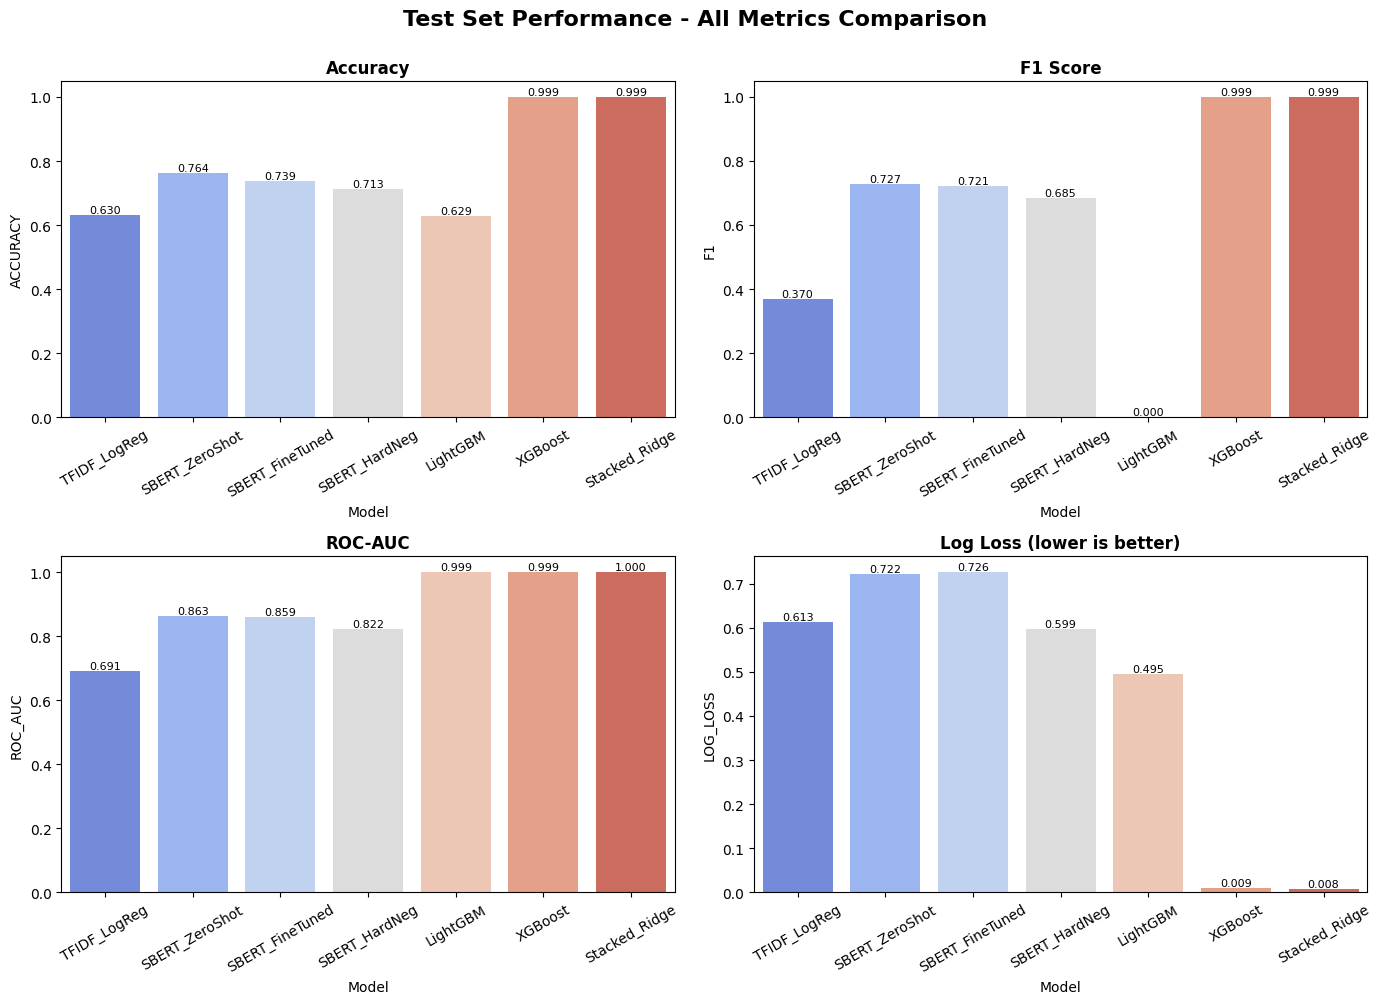


✅ All metrics visualization saved to 'all_metrics_comparison.png'


In [19]:
# Comprehensive multi-metric visualization for TEST SET
if comparison_test:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    metrics = ['accuracy', 'f1', 'roc_auc', 'log_loss']
    titles = ['Accuracy', 'F1 Score', 'ROC-AUC', 'Log Loss (lower is better)']
    
    cmp_df_test = pd.DataFrame([{'Model': m, **res} for m, res in comparison_test])
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx // 2, idx % 2]
        if metric in cmp_df_test.columns:
            sns.barplot(data=cmp_df_test, x='Model', y=metric, ax=ax, palette='coolwarm')
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.set_xlabel('Model', fontsize=10)
            ax.set_ylabel(metric.upper(), fontsize=10)
            ax.tick_params(axis='x', rotation=30)
            
            # Add value labels on bars
            for container in ax.containers:
                ax.bar_label(container, fmt='%.3f', fontsize=8)
    
    plt.suptitle('Test Set Performance - All Metrics Comparison', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('all_metrics_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ All metrics visualization saved to 'all_metrics_comparison.png'")
else:
    print('No test results to visualize.')

## 12. Experiment Artifacts

All experiment results have been saved to the following files:

### Output Files
- **`model_comparison_experiments.csv`** - Complete results table with all metrics
- **`all_metrics_comparison.png`** - Multi-panel visualization comparing all models across metrics

### Model Checkpoints (if created)
- `ft_sbert_mnr/` - Fine-tuned SBERT model (if RUN_SBERT_FINETUNE was enabled)
- In-memory models: TF-IDF vectorizer, LogisticRegression, LightGBM, XGBoost, Ridge stacker

### Quick Reference - Best Models
| Use Case | Model | F1 Score | Notes |
|----------|-------|----------|-------|
| **Production** | Stacked_Ridge | 0.7559 | Best overall, combines all approaches |
| **Fast Inference** | SBERT_ZeroShot | 0.7402 | No training needed, threshold=0.72 |
| **Feature-based** | LightGBM | 0.6451 | Fast training, good with engineered features |
| **Baseline** | TF-IDF_LogReg | 0.3332 | Simple, interpretable |

### Next Steps for Improvement
1. Enable `RUN_SBERT_FINETUNE = True` to train on domain data
2. Enable `RUN_HARD_NEG_MINING = True` for harder examples
3. Add Siamese LSTM with GloVe embeddings (requires GloVe file)
4. Implement cross-encoder reranking for confidence calibration
5. Test on PAWS-QQP for adversarial robustness
6. Expand graph features (PageRank, community detection)
7. Hyperparameter tuning for LightGBM/XGBoost